# CSTR system

This notebook explores solutions to the system discussed in Seborg, Edgar, Melichamp & Doyle "Process Dynamics and Control" (3rd Ed).

<img src='cstr.png'/>

## Model
$$\begin{align}
k &= k_0\exp\left(\frac{-E}{RT}\right)\\
w &=q\rho \\
V\frac{\mathrm{d}c_A}{\mathrm{d}t} &= q(c_{Ai} - c_A) - V k c_A \\
V\rho C\frac{\mathrm{d}T}{\mathrm{d}t} &= wC(T_i - T) + (-\Delta H_R) V k c_A + UA(T_c - T) 
\end{align}$$

EB: $$\frac{dE}{dt} = E_{in} - E_{out}$$

MB: $$\frac{dm}{dt} = \dot m_{in} - \dot m_{out}$$

CB: $$\frac{dN_A}{dt} = N_{A,in} - N_{A, out} + N_{A, \text{gen}} - N_{A, \text{consumed}}$$


In [1]:
import numpy
import scipy
import scipy.optimize
import scipy.integrate

Parameter values from Table 2.3

In [2]:
q = 100  # L/min
cA_i = 1  # mol/L
T_i = 350  # K 
V = 100  # L
rho = 1000 # g/L
C = 0.239 # J/(g K)
Hr = -5e4  # J/(g K)
E_over_R = 8750  # K
k0 = 7.2e10  # 1/min
UA = 5e4  # J/(min K)

This is the intial value of the input $T_c$

In [3]:
Tc = Tc0 = 300  # K

These are the initial values of the states given in the question. Notice that these are not 100 % accurate. When we simulate using these values, we don't get a perfect straight line (derivatives equal to zero) as we should when using the steady state values.

In [4]:
cA0 = 0.5  # mol/L
T0 = 350  # K 

We define the function to calculate the derivatives here.

In [5]:
def intsys(x, t):
    cA, T = x
    k = k0*numpy.exp(-E_over_R/T)
    w = q*rho
    dcAdt = q*(cA_i - cA)/V - k*cA
    dTdt = 1/(V*rho*C)*(w*C*(T_i - T) - Hr*V*k*cA + UA*(Tc - T))
    return dcAdt, dTdt

In [6]:
x0 = [cA0, T0]

Let's see what the derivatives look like at this "steady state"

In [7]:
intsys(x0, 0)

(3.4020861295225302e-05, -0.007117334999003795)

That doesn't seem very close to zero...

Now, let's simulate

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
t = numpy.linspace(0, 10, 1000)

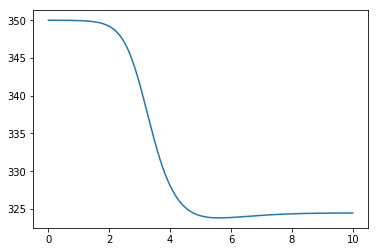

In [10]:
r = scipy.integrate.odeint(intsys, x0, t)
cA, T = r.T
plt.plot(t, T)
plt.show()

We see a significant deviation from the straight line we were expecting!

## Solve for steady state
Now, let's solve for a better initial value by setting the derivatives equal to zero

In [11]:
def ss(x):
    """ This wrapper function simply calls intsys with a zero time"""
    return intsys(x, 0)

We use fsolve to solve for a new steady state

In [12]:
x0 = scipy.optimize.fsolve(ss, x0)

Let's check that:

In [13]:
ss(x0)

(3.7614356074300304e-13, -7.8792227860773961e-11)

Much better, let's simulate:

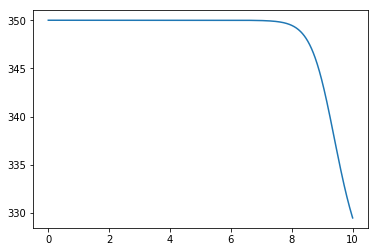

In [14]:
r = scipy.integrate.odeint(intsys, x0, t)
cA, T = r.T
plt.plot(t, T)
plt.show()

This is better, but it still seems as though these equations are quite hard to balance perfectly at the steady state, since starting quite close to zero derivatives still gave some deviation toward the end. Nonlinear differential equations often exhibit this high sensitivity to the initial value.

Now we are ready to reproduce the figure

/Users/alchemyst/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


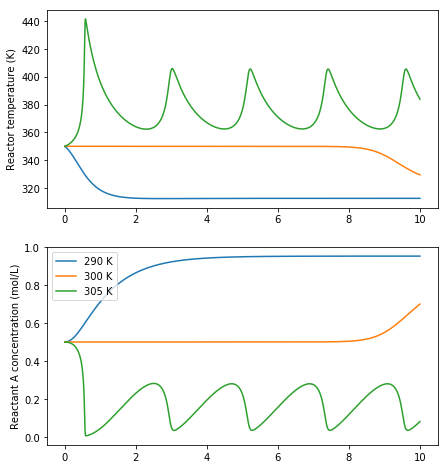

In [15]:
plt.figure(figsize=(7, 8))
for Tc in [290, 300, 305]:
    r = scipy.integrate.odeint(intsys, x0, t)
    cA, T = r.T
    plt.subplot(2, 1, 1)
    plt.plot(t, T, label='{} K'.format(Tc))
    plt.ylabel('Reactor temperature (K)')
    plt.subplot(2, 1, 2)
    plt.plot(t, cA, label='{} K'.format(Tc))    
    plt.ylabel('Reactant A concentration (mol/L)')
plt.legend()
plt.show()

## Nonlinear behaviour

Nonlinear differential equations like this can exhibit very strange behaviour. We may expect that increasing the cooling water temperature will always increase the reactor temperature, measured after a certain amount of time, but the oscillatory behaviour we see in the graphs above give us a clue that everything may not be as simple as it appears.

In [16]:
Tends = []
Tcs = numpy.linspace(300, 310, 1000)
for Tc in Tcs:
    r = scipy.integrate.odeint(intsys, x0, t)
    cA, T = r.T
    Tends.append(T[-1])

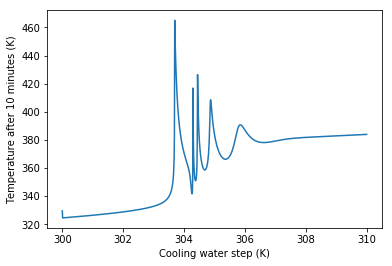

In [17]:
plt.plot(Tcs, Tends)
plt.ylabel('Temperature after 10 minutes (K)')
plt.xlabel('Cooling water step (K)')
plt.show()

We can see that there is often no easy explanation to system behavour like "Making x bigger will make y bigger". For nonlinear systems the answer to questions the direction of an effect is often very much "it depends"